# Airtickets data prep

##### Import packages

In [7]:
#pip install meteostat
#pip install roman

In [1]:
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
from meteostat import Point, Daily
import pandas as pd
import numpy
import roman
import re

### Weather table

In [2]:
# Set time period
start = datetime(2022, 4, 10)
end = datetime(2022, 5, 12)

df = pd.read_csv('long_lat_dle_codes_hlavni.csv', sep=";")
codes = df['Airport Code'].tolist()
lat = df['Latitude'].tolist()
long = df['Longitude'].tolist()
weather_table = pd.DataFrame()

for i in df.index:
    # Create Point
    location = Point(lat[i],long[i])
    # Get daily data
    data = Daily(location, start, end).fetch()
    data['Airport_Code']=codes[i]
    weather_table = pd.concat([weather_table, data])

In [3]:
weather_table['tavg_cat'] = pd.cut(weather_table['tavg'], 
                                   bins = [-float("inf"),0, 10,20,30, float("inf")], 
                                   labels = ['a) <0', 'b) 0-10', 'c) 10-20',
                                             'd) 20-30', 'e) 30+'])
weather_table['prcp_cat'] = pd.cut(weather_table['prcp'], 
                                   bins = [-float("inf"), 1,10,20,30, float("inf")], 
                                   labels = ['a) 0-1', 'b) 1-10', 'c) 10-20',
                                             'd) 20-30', 'e) 30+'])
weather_table['wspd_cat'] = pd.cut(weather_table['wspd'], 
                                   bins = [-float("inf"),5,19,38, float("inf")], 
                                   labels = ['a) Calm or Light Air',
                                             'b) Light or Gentle Breeze', 
                                             'c) Moderate or Fresh Breeze', 
                                             'd) Strong Breeze or worse'])
weather_table

,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun,Airport_Code,tavg_cat,prcp_cat,wspd_cat
time,,,,,,,,,,,,,,
2022-04-10,12.0,0.6,23.3,0.0,0.0,303.0,5.2,NaN,1018.5,NaN,ATL,c) 10-20,a) 0-1,b) Light or Gentle Breeze
2022-04-11,14.4,6.7,21.1,0.0,0.0,308.0,4.7,NaN,1019.6,NaN,ATL,c) 10-20,a) 0-1,a) Calm or Light Air
2022-04-12,19.4,11.7,27.2,0.0,0.0,265.0,7.6,NaN,1019.4,NaN,ATL,c) 10-20,a) 0-1,b) Light or Gentle Breeze
2022-04-13,21.2,16.7,25.0,0.0,0.0,173.0,12.2,NaN,1015.8,NaN,ATL,d) 20-30,a) 0-1,b) Light or Gentle Breeze
2022-04-14,19.7,15.6,23.9,1.0,0.0,283.0,12.2,NaN,1014.9,NaN,ATL,c) 10-20,a) 0-1,b) Light or Gentle Breeze
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-08,12.6,10.0,16.1,0.0,NaN,293.0,31.7,NaN,1016.7,NaN,SFO,c) 10-20,a) 0-1,c) Moderate or Fresh Breeze
2022-05-09,12.3,8.9,16.1,0.0,NaN,278.0,18.4,NaN,1018.3,NaN,SFO,c) 10-20,a) 0-1,b) Light or Gentle Breeze
2022-05-10,12.1,9.4,15.6,0.0,NaN,285.0,27.0,NaN,1021.9,NaN,SFO,c) 10-20,a) 0-1,c) Moderate or Fresh Breeze


In [ ]:
weather_table.to_csv(path_or_buf='weather_airports_hlavni.csv')

In [87]:
df = pd.read_csv('weather_airports_hlavni.csv')

In [88]:
df.rename(columns = {'Unnamed: 0' : 'w_index'}, inplace = True)
df['w_index'] = df['Airport_Code'] + ' ' + df['time']

In [90]:
df.to_csv(path_or_buf='weather_airports_hlavni.csv')

### Weekday table

In [72]:
weekday = pd.DataFrame(pd.date_range(start, end).weekday+1,
                       columns=['Weekday'])
weekday['den']=  pd.date_range(start, end).strftime("%a")
weekday['Weekday'] = weekday['Weekday'].apply(lambda x: str(x))
weekday['den'] = weekday['den'].apply(lambda x: str(x))
weekday['Weekday'] = weekday['Weekday'] + ' ' + weekday['den']
weekday.drop(labels=['den'], axis = 'columns', inplace = True)
weekday['Date'] = pd.date_range(start, end)
weekday.to_csv(path_or_buf='weekdays.csv', index = False)

## Itineraries table

In [55]:
df = pd.read_csv('itineraries-min-250k_orig.csv',
                 sep=",", low_memory= False )
df.columns

Index(['legId', 'searchDate', 'flightDate', 'startingAirport',
       'destinationAirport', 'fareBasisCode', 'travelDuration', 'elapsedDays',
       'isBasicEconomy', 'isRefundable', 'isNonStop', 'baseFare', 'totalFare',
       'seatsRemaining', 'totalTravelDistance',
       'segmentsDepartureTimeEpochSeconds', 'segmentsDepartureTimeRaw',
       'segmentsArrivalTimeEpochSeconds', 'segmentsArrivalTimeRaw',
       'segmentsArrivalAirportCode', 'segmentsDepartureAirportCode',
       'segmentsAirlineName', 'segmentsAirlineCode',
       'segmentsEquipmentDescription', 'segmentsDurationInSeconds',
       'segmentsDistance', 'segmentsCabinCode'],
      dtype='object')

In [56]:
max(df['segmentsDepartureTimeEpochSeconds'].str.count('\\|\\|')) 
#abych vedela, kolik novych sloupcu je potreba vytvorit

3

#### New columns

In [57]:
df[['1st_segmentDepartureTimeEpochSeconds','2nd_segmentDepartureTimeEpochSeconds','3rd_segmentDepartureTimeEpochSeconds',
    '4th_segmentDepartureTimeEpochSeconds']]=df['segmentsDepartureTimeEpochSeconds'].str.split('\\|\\|', expand = True).fillna('')
df[['1st_segmentDepartureTimeRaw','2nd_segmentDepartureTimeRaw','3rd_segmentDepartureTimeRaw',
    '4th_segmentDepartureTimeRaw']]=df['segmentsDepartureTimeRaw'].str.split('\\|\\|', expand = True).fillna('')
df[['1st_segmentArrivalTimeEpochSeconds','2nd_segmentArrivalTimeEpochSeconds','3rd_segmentArrivalTimeEpochSeconds',
    '4th_segmentArrivalTimeEpochSeconds']]=df['segmentsArrivalTimeEpochSeconds'].str.split('\\|\\|', expand = True).fillna('')
df[['1st_segmentArrivalTimeRaw','2nd_segmentArrivalTimeRaw','3rd_segmentArrivalTimeRaw',
    '4th_segmentArrivalTimeRaw']]=df['segmentsArrivalTimeRaw'].str.split('\\|\\|', expand = True).fillna('')
df[['1st_segmentArrivalAirportCode','2nd_segmentArrivalAirportCode','3rd_segmentArrivalAirportCode',
    '4th_segmentArrivalAirportCode']]=df['segmentsArrivalAirportCode'].str.split('\\|\\|', expand = True).fillna('')
df[['1st_segmentDepartureAirportCode','2nd_segmentDepartureAirportCode','3rd_segmentDepartureAirportCode',
    '4th_segmentDepartureAirportCode']]=df['segmentsDepartureAirportCode'].str.split('\\|\\|', expand = True).fillna('')
df[['1st_segmentAirlineName','2nd_segmentAirlineName','3rd_segmentAirlineName',
    '4th_segmentAirlineName']]=df['segmentsAirlineName'].str.split('\\|\\|', expand = True).fillna('')
df[['1st_segmentEquipmentDescription','2nd_segmentEquipmentDescription','3rd_segmentEquipmentDescription',
    '4th_segmentEquipmentDescription']]=df['segmentsEquipmentDescription'].str.split('\\|\\|', expand = True).fillna('')
df[['1st_segmentDurationInSeconds','2nd_segmentDurationInSeconds','3rd_segmentDurationInSeconds',
    '4th_segmentDurationInSeconds']]=df['segmentsDurationInSeconds'].str.split('\\|\\|', expand = True).fillna('')
df[['1st_segmentDistance','2nd_segmentDistance','3rd_segmentDistance',
    '4th_segmentDistance']]=df['segmentsDistance'].str.split('\\|\\|', expand = True).fillna('')
df[['1st_segmentCabinCode','2nd_segmentCabinCode','3rd_segmentCabinCode',
    '4th_segmentCabinCode']]=df['segmentsCabinCode'].str.split('\\|\\|', expand = True).fillna('')

##### New column CabinCodeSummary

In [58]:
def remove_empty(set_value):
    return set(filter(None, set_value))

ccs = df.loc[:,['1st_segmentCabinCode', '2nd_segmentCabinCode', 
                '3rd_segmentCabinCode','4th_segmentCabinCode'
               ]].apply(remove_empty, axis=1)

def join_items(set_value):
    return '|'.join(set_value)

df['CabinCodeSummary'] = ccs.apply(join_items)
#kontrola:   df.loc[249911, 'CabinCodeSummary']

##### New columns AirlineNameSummary a AirlineNameCount

In [59]:
def remove_empty(set_value):
    return set(filter(lambda x: x != "" and not pd.isna(x), set_value))

ccs = df.loc[:,['1st_segmentAirlineName', '2nd_segmentAirlineName', 
                '3rd_segmentAirlineName', '4th_segmentAirlineName'
               ]].apply(remove_empty, axis=1)

def join_items(set_value):
    return '|'.join(set_value)

df['AirlineNameSummary'] = ccs.apply(join_items)
df['AirlineNameCount'] = ccs.apply(lambda x: len(x))
#kontrola:   df.loc[25287, 'AirlineNameSummary']

##### New columns EquipmentDescriptionSummary

In [60]:
for i in range(250000):
    for j in range(df.columns.get_loc('1st_segmentEquipmentDescription'),
                   df.columns.get_loc('4th_segmentEquipmentDescription')+1):
        if pd.isnull(df.iloc[i,j]) == False:
            if 'airbus'.upper() in df.iloc[i,j].upper():
                df.iloc[i,j] = 'Airbus'
            elif 'boeing'.upper() in df.iloc[i,j].upper():
                df.iloc[i,j] = 'Boeing'
            else:
                df.iloc[i,j] = 'Other'

In [61]:
ccs = df.loc[:,['1st_segmentEquipmentDescription', 
                '2nd_segmentEquipmentDescription', 
                '3rd_segmentEquipmentDescription',
                '4th_segmentEquipmentDescription'
               ]].apply(remove_empty, axis=1)

df['EquipmentDescriptionSummary'] = ccs.apply(join_items)

##### New column NumberOfTransfers

In [62]:
df['NumberOfTransfers']=df[['1st_segmentDepartureTimeEpochSeconds',
       '2nd_segmentDepartureTimeEpochSeconds',
       '3rd_segmentDepartureTimeEpochSeconds',
       '4th_segmentDepartureTimeEpochSeconds'
                           ]].apply(lambda row:
                                    sum(1 for cell in row if cell != '')-1,
                                    axis=1)

##### New column DaysToFlight

In [63]:
df['DaysToFlight'] = (df['flightDate'].apply(
    lambda x: datetime.strptime(x, '%Y-%m-%d'))
                      - df['searchDate'].apply(
                          lambda x: datetime.strptime(x, '%Y-%m-%d')
                      )).apply(lambda x: x.days)

##### New column TotalDurationInSeconds

In [64]:
df['TotalDurationInSeconds'] = df[['1st_segmentDurationInSeconds',
                                   '2nd_segmentDurationInSeconds', 
                                   '3rd_segmentDurationInSeconds',
                                   '4th_segmentDurationInSeconds'
                                  ]].apply(pd.to_numeric).sum(axis=1)

##### New column TotalTravelDuration

In [65]:
df['TotalTravelDuration']=df.apply(lambda row: pd.to_numeric(
    row.iloc[df.columns.get_loc('1st_segmentArrivalTimeEpochSeconds') 
    + row['NumberOfTransfers']]),axis=1)-df['1st_segmentDepartureTimeEpochSeconds'].apply(
    pd.to_numeric)

##### New column WaitingTime

In [7]:
# Některé hodnoty atributu baseFare byly chybně nahrány, je proto nutné je opravit, aby byl atribut brán jako čiselný a nikoliv jako string

# Vytvoření množiny všech hodnot, které nelze převést na čísla 
numeric_values = pd.to_numeric(df['baseFare'], errors='coerce')
failed_conversions = df['baseFare'][numeric_values.isna()].tolist()
chyby = list(set(failed_conversions))
opravy = {}

# oprava těchto hodnot v tabulce
for i in range(len(chyby)):
    text = ''
    cislo = ''
    for j in range(len(chyby[i])):
        if isinstance(pd.to_numeric(chyby[i][j], errors ='ignore'), str) and chyby[i][j] != '.':
            text = text + chyby[i][j]
        elif not isinstance(pd.to_numeric(chyby[i][j], errors ='ignore'), str):
            cislo = cislo + chyby[i][j]
    prevod = str(roman.fromRoman(text))
    if isinstance(pd.to_numeric(chyby[i][0], errors ='ignore'), str):
        value = prevod+'.'+cislo
    else:
        value = cislo +'.'+prevod
    opravy[chyby[i]] = value
df['baseFare'] = df['baseFare'].replace(opravy)
df['baseFare'] = pd.to_numeric(df['baseFare'])

In [66]:
df['WaitingTime'] = df['TotalTravelDuration'] - df['TotalDurationInSeconds']

##### New column TotalTravelDurationInHours and WaitingTimeInHours

In [103]:
df['TotalTravelDurationInHours'] = round(df['TotalTravelDuration']/3600,2)
df['WaitingTimeInHours'] = round(df['WaitingTime']/3600,2)

##### New column increaseFare

In [67]:
df['increaseFare'] = round((df['totalFare']*100 /df['baseFare'] )-100)

##### New column arr_hour

In [69]:
df['arr_hour'] = df.apply(lambda row: datetime.fromisoformat(
    row.iloc[df.columns.get_loc('1st_segmentArrivalTimeRaw')
    + row['NumberOfTransfers']]).hour, axis=1)

### Kategorizace proměnných

##### New column dep_time_cat

In [70]:
def extract_characters(text):
    if len(text) == 29:
        return int(text[11:13])
    else:
        return "error"

# Aplikace funkce na sloupec 1st_segmentDepartureTimeRaw
df['dep_time_cat']=pd.cut(df['1st_segmentDepartureTimeRaw'].apply(extract_characters), 
                          bins = [-float("inf"),5,11,17,float("inf")], 
                          labels = ['d) Night', 'a) Morning', 
                                    'b) Afternoon', 'c) Evening'])
#hodina odletu na 1. prestupu

##### New column arr_time_cat

In [71]:
df['arr_time_cat'] = pd.cut(df['arr_hour'], 
                            bins = [-float("inf"),5,11,17,float("inf")], 
                            labels = ['d) Night', 'a) Morning', 
                                      'b) Afternoon', 'c) Evening'])

##### New column DaysToFlight_cat

In [72]:
df['DaysToFlight_cat'] = pd.cut(df['DaysToFlight'], 
                                bins = [-float("inf"),3,7,10, float("inf")], 
                                labels = ['a) < 4 Days', 'b) 4 - 7 Days', 
                                          'c) 8 - 10 Days', 'd) 11+ Days'])

##### New columns totalFare_cat a increaseFare_cat

In [75]:
df['totalFare_cat'] = pd.cut(df['totalFare'], 
                             bins = [-float("inf"),200,300, 400,float("inf")], 
                             labels = ['a) <200 USD', 'b) 200-300 USD', 
                                       'c) 300-400 USD', 'd) 400+ USD'])
df['increaseFare_cat'] = pd.qcut(round((df['totalFare']*100 /df['baseFare'] )-100),
                                 4, 
                                 labels = ['a) <13 %', 'b) 13-16 %', 
                                           'c) 16-21 %', 'd) 21+ %'])

##### New columns Tot_Trav_Duration_cat and Wait_time_cat

In [73]:
df['Tot_Trav_Duration_cat'] = pd.cut(df['TotalTravelDuration'], 
                                     bins = [-float("inf"),14400,25200,36000, float("inf")], 
                                     labels = ['a) <4 h', 'b) 4-7 h', 'c) 7-10 h', 'd) 10+ h'])
df['Wait_time_cat'] = pd.cut(df['WaitingTime'], 
                             bins = [-float("inf"),0,7200, float("inf")], 
                             labels = ['a) 0 h', 'b) 0-2 h', 'c) 2+ h'])

##### New column totalTravelDistance_cat

In [74]:
df['totalTravelDistance_cat'] = pd.cut(df['totalTravelDistance'], 
                                       bins = [-float("inf"),1000,2000, float("inf")], 
                                       labels = ['a) less than 1000 miles', 
                                                 'b) 1000-2000 miles', 
                                                 'c) more than 2000 miles'])

In [76]:
a = pd.qcut(round((df['totalFare']*100 /df['baseFare'] )-100), 4)
df2 = pd.DataFrame({'c1':df['isBasicEconomy'], 'c2':a, 'c3':[1] * len(a)})
pd.pivot_table(df2, columns =['c1'], index = 'c2', aggfunc='count')

c3       
c1              False  True 
c2                          
(7.999, 13.0]   69106     31
(13.0, 16.0]    70045   1181
(16.0, 21.0]    47203   6446
(21.0, 2000.0]  43588  12400

##### New ID columns

In [80]:
df['arrivalDate'] = df.apply(
    lambda row: (datetime.strptime(row['flightDate'], '%Y-%m-%d') 
                 + timedelta(days=row['elapsedDays'])
                ).strftime('%Y-%m-%d') 
    if row['elapsedDays'] != 0 else row['flightDate'], axis=1)

In [82]:
df['a_dep_index'] = df['startingAirport'] + ' ' + df['flightDate']
df['a_arr_index'] = df['destinationAirport'] + ' ' + df['arrivalDate']

### Smazání nepotřebných slouců a uložení jako nové csv

In [85]:
df['isRefundable'].value_counts()

isRefundable
False    249996
True          4
Name: count, dtype: int64

In [84]:
df.drop(labels=['legId', 'fareBasisCode', 'segmentsAirlineCode', 'segmentsDepartureTimeEpochSeconds', 
                'segmentsDepartureTimeRaw', 'segmentsArrivalTimeEpochSeconds', 'segmentsArrivalTimeRaw',
                'segmentsArrivalAirportCode', 'segmentsDepartureAirportCode', 'segmentsAirlineName', 
                'segmentsEquipmentDescription', 'segmentsDurationInSeconds', 'segmentsDistance', 
                'segmentsCabinCode'], axis = 'columns', inplace = True)

In [86]:
df.drop(labels=['isRefundable',
'1st_segmentDepartureTimeEpochSeconds','2nd_segmentDepartureTimeEpochSeconds',
                '3rd_segmentDepartureTimeEpochSeconds','4th_segmentDepartureTimeEpochSeconds',
'1st_segmentDepartureTimeRaw','2nd_segmentDepartureTimeRaw',
                '3rd_segmentDepartureTimeRaw','4th_segmentDepartureTimeRaw',
'1st_segmentArrivalTimeEpochSeconds','2nd_segmentArrivalTimeEpochSeconds',
                '3rd_segmentArrivalTimeEpochSeconds','4th_segmentArrivalTimeEpochSeconds',
'1st_segmentArrivalTimeRaw','2nd_segmentArrivalTimeRaw',
                '3rd_segmentArrivalTimeRaw','4th_segmentArrivalTimeRaw',
'1st_segmentArrivalAirportCode','2nd_segmentArrivalAirportCode',
                '3rd_segmentArrivalAirportCode','4th_segmentArrivalAirportCode',
'1st_segmentDepartureAirportCode','2nd_segmentDepartureAirportCode',
                '3rd_segmentDepartureAirportCode','4th_segmentDepartureAirportCode',
'1st_segmentAirlineName','2nd_segmentAirlineName',
                '3rd_segmentAirlineName','4th_segmentAirlineName',
'1st_segmentEquipmentDescription','2nd_segmentEquipmentDescription',
                '3rd_segmentEquipmentDescription','4th_segmentEquipmentDescription',
'1st_segmentDistance','2nd_segmentDistance','3rd_segmentDistance','4th_segmentDistance',
'1st_segmentCabinCode','2nd_segmentCabinCode','3rd_segmentCabinCode','4th_segmentCabinCode',
'travelDuration', 'arr_hour'], axis = 'columns', inplace = True)

In [104]:
df.columns

Index(['searchDate', 'flightDate', 'startingAirport', 'destinationAirport',
       'elapsedDays', 'isBasicEconomy', 'isNonStop', 'baseFare', 'totalFare',
       'seatsRemaining', 'totalTravelDistance', '1st_segmentDurationInSeconds',
       '2nd_segmentDurationInSeconds', '3rd_segmentDurationInSeconds',
       '4th_segmentDurationInSeconds', 'CabinCodeSummary',
       'AirlineNameSummary', 'AirlineNameCount', 'EquipmentDescriptionSummary',
       'NumberOfTransfers', 'DaysToFlight', 'TotalDurationInSeconds',
       'TotalTravelDuration', 'WaitingTime', 'increaseFare', 'dep_time_cat',
       'arr_time_cat', 'DaysToFlight_cat', 'Tot_Trav_Duration_cat',
       'Wait_time_cat', 'totalTravelDistance_cat', 'totalFare_cat',
       'increaseFare_cat', 'arrivalDate', 'a_dep_index', 'a_arr_index',
       'TotalTravelDurationInHours', 'WaitingTimeInHours'],
      dtype='object')

In [105]:
df.to_csv(path_or_buf='itineraries_250k_final3.csv')

# Preparation for CleverMiner 

In [2]:
weather = pd.read_csv('weather_airports_hlavni.csv')
weather.drop(labels=['Unnamed: 0','time', 'tavg', 'tmin', 'tmax', 'prcp', 'snow',
       'wdir', 'wspd', 'wpgt', 'pres', 'tsun', 'Airport_Code'], axis = 'columns', inplace = True)
weekdays = pd.read_csv('weekdays.csv')
df = pd.read_csv('itineraries_250k_final3.csv', low_memory= False )
df = df[['a_dep_index', 'a_arr_index', 'flightDate',
       'startingAirport', 'destinationAirport', 'elapsedDays',
       'isBasicEconomy', 'isNonStop',
       'seatsRemaining', 
       'CabinCodeSummary', 'NumberOfTransfers', 'dep_time_cat', 'arr_time_cat', 'Tot_Trav_Duration_cat',
       'Wait_time_cat', 'increaseFare_cat',
       'totalFare_cat', 'totalTravelDistance_cat', 'AirlineNameSummary',
       'AirlineNameCount', 'EquipmentDescriptionSummary', 'DaysToFlight_cat']]
matice = pd.merge(df, weather, how="left", left_on='a_arr_index', right_on ='w_index')
matice = pd.merge(matice, weekdays, how="left", left_on='flightDate', right_on ='Date')
matice.drop(labels=['a_dep_index', 'w_index', 'Date'], axis = 'columns', inplace = True)
matice.head()

,a_arr_index,flightDate,startingAirport,destinationAirport,elapsedDays,isBasicEconomy,isNonStop,seatsRemaining,CabinCodeSummary,NumberOfTransfers,...,totalFare_cat,totalTravelDistance_cat,AirlineNameSummary,AirlineNameCount,EquipmentDescriptionSummary,DaysToFlight_cat,tavg_cat,prcp_cat,wspd_cat,Weekday
0,BOS 2022-04-17,2022-04-17,ATL,BOS,0.0,False,True,9.0,coach,0,...,b) 200-300 USD,a) less than 1000 miles,Delta,1,Other|Airbus,a) < 4 Days,b) 0-10,a) 0-1,c) Moderate or Fresh Breeze,7 Sun
1,BOS 2022-04-17,2022-04-17,ATL,BOS,0.0,False,True,4.0,coach,0,...,b) 200-300 USD,a) less than 1000 miles,Delta,1,Other|Airbus,a) < 4 Days,b) 0-10,a) 0-1,c) Moderate or Fresh Breeze,7 Sun
2,BOS 2022-04-17,2022-04-17,ATL,BOS,0.0,False,True,9.0,coach,0,...,b) 200-300 USD,a) less than 1000 miles,Delta,1,Other|Boeing,a) < 4 Days,b) 0-10,a) 0-1,c) Moderate or Fresh Breeze,7 Sun
3,BOS 2022-04-17,2022-04-17,ATL,BOS,0.0,False,True,8.0,coach,0,...,b) 200-300 USD,a) less than 1000 miles,Delta,1,Other|Airbus,a) < 4 Days,b) 0-10,a) 0-1,c) Moderate or Fresh Breeze,7 Sun
4,BOS 2022-04-17,2022-04-17,ATL,BOS,0.0,False,True,9.0,coach,0,...,b) 200-300 USD,a) less than 1000 miles,Delta,1,Other|Airbus,a) < 4 Days,b) 0-10,a) 0-1,c) Moderate or Fresh Breeze,7 Sun


In [3]:
matice.columns

Index(['a_arr_index', 'flightDate', 'startingAirport', 'destinationAirport',
       'elapsedDays', 'isBasicEconomy', 'isNonStop', 'seatsRemaining',
       'CabinCodeSummary', 'NumberOfTransfers', 'dep_time_cat', 'arr_time_cat',
       'Tot_Trav_Duration_cat', 'Wait_time_cat', 'increaseFare_cat',
       'totalFare_cat', 'totalTravelDistance_cat', 'AirlineNameSummary',
       'AirlineNameCount', 'EquipmentDescriptionSummary', 'DaysToFlight_cat',
       'tavg_cat', 'prcp_cat', 'wspd_cat', 'Weekday'],
      dtype='object')

# Random Forest - Prediction of TotalFare_cat

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score,f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import auc, roc_curve, roc_auc_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import LabelBinarizer
import seaborn as sns

In [11]:
encoded_data = pd.get_dummies( matice.drop(['totalFare_cat','a_arr_index','index', 'flightDate', 'increaseFare_cat', 'EquipmentDescriptionSummary'], axis=1) , drop_first=True)
encoded_data.head()

,elapsedDays,isBasicEconomy,isNonStop,seatsRemaining,NumberOfTransfers,AirlineNameCount,startingAirport_BOS,startingAirport_CLT,startingAirport_DEN,startingAirport_DFW,...,prcp_cat_e) 30+,wspd_cat_b) Light or Gentle Breeze,wspd_cat_c) Moderate or Fresh Breeze,wspd_cat_d) Strong Breeze or worse,Weekday_2 Tue,Weekday_3 Wed,Weekday_4 Thu,Weekday_5 Fri,Weekday_6 Sat,Weekday_7 Sun
0,0.0,False,True,9.0,0.0,1,False,False,False,False,...,False,False,True,False,False,False,False,False,False,True
1,0.0,False,True,4.0,0.0,1,False,False,False,False,...,False,False,True,False,False,False,False,False,False,True
2,0.0,False,True,9.0,0.0,1,False,False,False,False,...,False,False,True,False,False,False,False,False,False,True
3,0.0,False,True,8.0,0.0,1,False,False,False,False,...,False,False,True,False,False,False,False,False,False,True
4,0.0,False,True,9.0,0.0,1,False,False,False,False,...,False,False,True,False,False,False,False,False,False,True


In [12]:
X = encoded_data  # Features
y = matice['totalFare_cat']  # Target variable

In [13]:
# Rozdělení datasetu na trénovací a testovací v poměru 80:20. Random state, který zajistí reproducibilitu je 42. Parametr stratify=y zajistí,
# že budou proporce datasetu vyváženy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [14]:
rf_classifier = RandomForestClassifier(n_estimators=50, random_state=42)

rf_classifier.fit(X_train, y_train)

y_pred_rf = rf_classifier.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy: {accuracy_rf}")

Accuracy: 0.85394


In [15]:
report_rf = classification_report(y_test, y_pred_rf)
print(report_rf)

                precision    recall  f1-score   support

   a) >200 USD       0.89      0.90      0.90     12233
b) 200-300 USD       0.81      0.81      0.81     12015
c) 300-400 USD       0.79      0.77      0.78     10689
   d) 400+ USD       0.90      0.91      0.91     15063

      accuracy                           0.85     50000
     macro avg       0.85      0.85      0.85     50000
  weighted avg       0.85      0.85      0.85     50000



In [16]:
# Model interpretation
importances = rf_classifier.feature_importances_

feature_importance = list(zip(importances, X.columns))  # Replace 'X' with your feature DataFrame
feature_importance.sort(reverse=True)

for importance, feature in feature_importance:
    print(f"Feature: {feature}, Importance: {importance}")

Feature: seatsRemaining, Importance: 0.07958309361135785
Feature: AirlineNameCount, Importance: 0.04322402748835587
Feature: isBasicEconomy, Importance: 0.03341949768887753
Feature: totalTravelDistance_cat_c) more than 2000 miles, Importance: 0.03209539528656629
Feature: DaysToFlight_cat_d) 11+ Days, Importance: 0.023309635505606902
Feature: arr_time_cat_b) Afternoon, Importance: 0.021890388556846857
Feature: dep_time_cat_b) Afternoon, Importance: 0.021843215820628623
Feature: DaysToFlight_cat_c) 8 - 10 Days, Importance: 0.020762267791544997
Feature: NumberOfTransfers, Importance: 0.019395214164214806
Feature: AirlineNameSummary_American Airlines, Importance: 0.018391078907839874
Feature: arr_time_cat_c) Evening, Importance: 0.018000422959156832
Feature: Weekday_2 Tue, Importance: 0.01709503024373418
Feature: startingAirport_LGA, Importance: 0.016848849519332323
Feature: dep_time_cat_d) Night, Importance: 0.016793369051041576
Feature: Weekday_7 Sun, Importance: 0.016513226839977326
Fea

In [17]:
#bestparam: max_depth = None, min_samples_split = 2, n_estimators = 200
# Accuracy: 0.85464
# temer zadne zlepseni v tomto pripade 

In [17]:
# hyperparameter tuning of the model
# parameter grid

param_dist = {
'n_estimators': [100, 150, 200],
'max_depth': [None, 5, 10],
'min_samples_split': [2, 5, 10]
}

rf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(rf, param_dist, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")
rf_tuned = RandomForestClassifier(**best_params, random_state=42)
rf_tuned.fit(X_train, y_train)

Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}


RandomForestClassifier(n_estimators=200, random_state=42)

In [18]:
y_pred_rf_tuned = rf_tuned.predict(X_test)

accuracy_rf_tuned = accuracy_score(y_test, y_pred_rf_tuned)
print(f"Accuracy: {accuracy_rf_tuned}")

Accuracy: 0.85464


In [19]:
report_rf_tuned = classification_report(y_test, y_pred_rf_tuned)
print(report_rf_tuned)

                precision    recall  f1-score   support

   a) >200 USD       0.89      0.90      0.90     12233
b) 200-300 USD       0.81      0.81      0.81     12015
c) 300-400 USD       0.79      0.77      0.78     10689
   d) 400+ USD       0.90      0.91      0.91     15063

      accuracy                           0.85     50000
     macro avg       0.85      0.85      0.85     50000
  weighted avg       0.85      0.85      0.85     50000



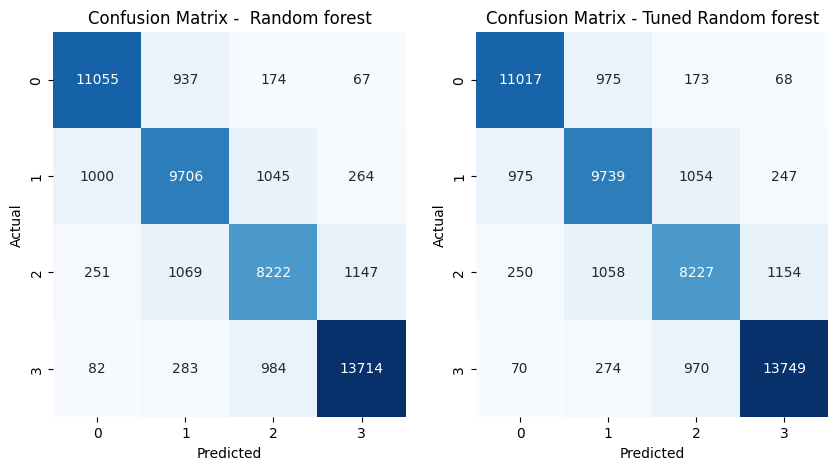

In [22]:
# Vykreslení Confusion Matrix pro oba rozhodovací stromy
cm_rf = confusion_matrix(y_test, y_pred_rf)
cm_rf_tuned = confusion_matrix(y_test, y_pred_rf_tuned)

fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1, 2, 1)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix -  Random forest')

ax2 = fig.add_subplot(1, 2, 2)
sns.heatmap(cm_rf_tuned, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Tuned Random forest')
plt.show()

In [35]:
n_classes = len(numpy.unique(y))

In [30]:
rf_classifier.predict_proba(X_test)

array([[0.02      , 0.18571429, 0.27428571, 0.52      ],
       [1.        , 0.        , 0.        , 0.        ],
       [0.        , 0.04      , 0.08      , 0.88      ],
       ...,
       [0.74      , 0.24      , 0.02      , 0.        ],
       [0.02      , 0.28      , 0.08      , 0.62      ],
       [0.16      , 0.78      , 0.04      , 0.02      ]])

In [31]:
# Porovnání ROC a AUC
y_pred_prob_rf = rf_classifier.predict_proba(X_test)
y_pred_prob_rf_tuned = rf_tuned.predict_proba(X_test)

In [28]:
label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
y_onehot_test.shape  # (n_samples, n_classes)
y_onehot_test

array([[0, 0, 1, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       ...,
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 1, 0, 0]])

In [42]:
macro_roc_auc_ovr = roc_auc_score(
    y_test,
    y_pred_prob_rf_tuned,
    multi_class="ovr",
    average="macro",
)

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{macro_roc_auc_ovr:.2f}")

Macro-averaged One-vs-Rest ROC AUC score:
0.97


In [40]:
fpr, tpr, roc_auc = dict(), dict(), dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_pred_prob_rf_tuned[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = numpy.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = numpy.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += numpy.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

print(f"Macro-averaged One-vs-Rest ROC AUC score for Tuned Model:\n{roc_auc['macro']:.2f}")

Macro-averaged One-vs-Rest ROC AUC score:
0.97


In [46]:
fpr2, tpr2, roc_auc2 = dict(), dict(), dict()
for i in range(n_classes):
    fpr2[i], tpr2[i], _ = roc_curve(y_onehot_test[:, i], y_pred_prob_rf[:, i])
    roc_auc2[i] = auc(fpr2[i], tpr2[i])

fpr_grid2 = numpy.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr2 = numpy.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr2 += numpy.interp(fpr_grid2, fpr2[i], tpr2[i])  # linear interpolation

# Average it and compute AUC
mean_tpr2 /= n_classes

fpr2["macro"] = fpr_grid2
tpr2["macro"] = mean_tpr2
roc_auc2["macro"] = auc(fpr2["macro"], tpr2["macro"])

print(f"Macro-averaged One-vs-Rest ROC AUC score for Non-Tuned Model:\n{roc_auc2['macro']:.2f}")

Macro-averaged One-vs-Rest ROC AUC score for Non-Tuned Model:
0.97


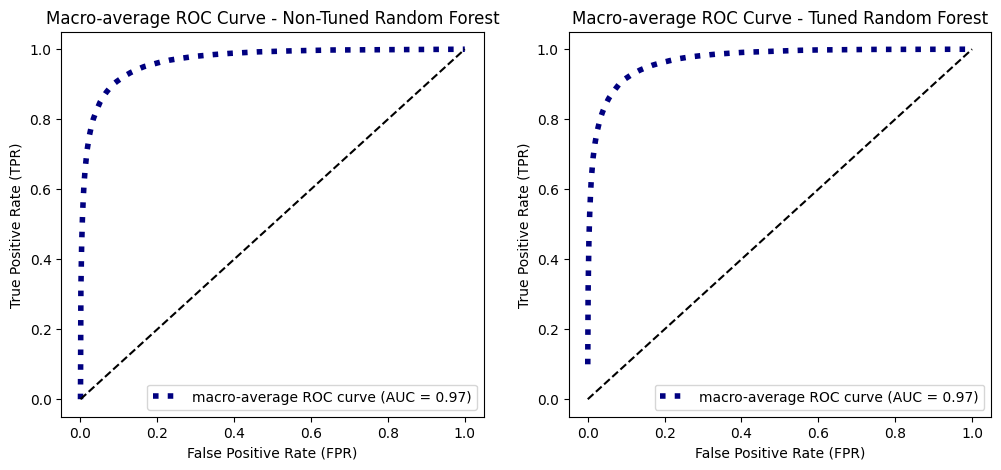

In [54]:
fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(1, 2, 1)
plt.plot(
    fpr2["macro"],
    tpr2["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc2['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Macro-average ROC Curve - Non-Tuned Random Forest')
plt.legend()

ax2 = fig.add_subplot(1, 2, 2)
plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Macro-average ROC Curve - Tuned Random Forest')
plt.legend()

plt.show()

# Asociation Rules in CleverMiner

In [3]:
from cleverminer import cleverminer

Automatically reordering numeric categories ...done
Cleverminer version  1.0.10


## 4ft-Miner

In [122]:
clm = cleverminer(df=matice,proc='4ftMiner',
               quantifiers= {'conf':0.4, 'Base':50},
               ante ={
                    'attributes':[
                        {'name': 'DaysToFlight_cat', 'type':'one', 'value': 'd) 11+ Days'},
                        {'name': 'startingAirport', 'type': 'subset', 'minlen': 1, 'maxlen':1},
                        {'name': 'destinationAirport', 'type': 'subset', 'minlen': 1, 'maxlen': 1}
                    ], 'minlen':3, 'maxlen':3, 'type':'con'},
               succ ={
                    'attributes':[
                        {'name': 'seatsRemaining', 'type':'lcut', 'minlen': 1, 'maxlen':2},
                    ], 'minlen':1, 'maxlen':1, 'type':'con'},
               )


clm.print_summary()
clm.print_rulelist()
clm.print_rule(1)

Cleverminer version 1.0.10.
Starting data preparation ...
Automatically reordering numeric categories ...
Encoding columns into bit-form...
Encoding columns into bit-form...done
Data preparation finished.
Will go for  4ftMiner
Starting to mine rules.
100%|####################################################|Elapsed Time: 0:00:0000
Done. Total verifications : 507, rules 1, times: prep 2.34sec, processing 0.43sec

CleverMiner task processing summary:

Task type : 4ftMiner
Number of verifications : 507
Number of rules : 1
Total time needed : 00h 00m 02s
Time of data preparation : 00h 00m 02s
Time of rule mining : 00h 00m 00s


List of rules:
RULEID BASE  CONF  AAD    Rule
     1   104 0.446 +1.531 DaysToFlight_cat(d) 11+ Days) & startingAirport(DTW) & destinationAirport(EWR) => seatsRemaining(0 1) | ---



Rule id : 1

Base :   104  Relative base : 0.000  CONF : 0.446  AAD : +1.531  BAD : -1.531

Cedents:
  antecedent : DaysToFlight_cat(d) 11+ Days) & startingAirport(DTW) & destinationAir

In [7]:


# drahe kratsi lety
clm = cleverminer(df=matice,proc='4ftMiner',
               quantifiers= {'conf':0.7, 'Base':50},
               ante ={
                    'attributes':[
                        {'name': 'Tot_Trav_Duration_cat', 'type':'lcut', 'minlen': 1, 'maxlen':2},
                        {'name': 'startingAirport', 'type': 'subset', 'minlen': 1, 'maxlen':1},
                        {'name': 'destinationAirport', 'type': 'subset', 'minlen': 1, 'maxlen': 1}
                    ], 'minlen':3, 'maxlen':3, 'type':'con'},
               succ ={
                    'attributes':[
                        {'name': 'totalFare_cat', 'type':'rcut', 'minlen': 1, 'maxlen':1},
                    ], 'minlen':1, 'maxlen':1, 'type':'con'},
               )


clm.print_summary()
clm.print_rulelist()
clm.print_rule(1)



Cleverminer version 1.0.10.
Starting data preparation ...
Automatically reordering numeric categories ...
Encoding columns into bit-form...
Encoding columns into bit-form...done
Data preparation finished.
Will go for  4ftMiner
Starting to mine rules.
100%|####################################################|Elapsed Time: 0:00:0000
Done. Total verifications : 212, rules 11, times: prep 2.48sec, processing 0.24sec

CleverMiner task processing summary:

Task type : 4ftMiner
Number of verifications : 212
Number of rules : 11
Total time needed : 00h 00m 02s
Time of data preparation : 00h 00m 02s
Time of rule mining : 00h 00m 00s


List of rules:
RULEID BASE  CONF  AAD    Rule
     1   127 0.901 +1.990 Tot_Trav_Duration_cat(a) <4 h b) 4-7 h) & startingAirport(ATL) & destinationAirport(SFO) => totalFare_cat(d) 400+ USD) | ---
     2    67 0.798 +1.648 Tot_Trav_Duration_cat(a) <4 h b) 4-7 h) & startingAirport(CLT) & destinationAirport(SFO) => totalFare_cat(d) 400+ USD) | ---
     3   189 0.867

In [4]:
# levne delsi lety 
clm = cleverminer(df=matice,proc='4ftMiner',
               quantifiers= {'conf':0.7, 'Base':50},
               ante ={
                    'attributes':[
                        {'name': 'Tot_Trav_Duration_cat', 'type':'rcut', 'minlen': 1, 'maxlen':2},
                        {'name': 'startingAirport', 'type': 'subset', 'minlen': 1, 'maxlen':1},
                        {'name': 'destinationAirport', 'type': 'subset', 'minlen': 1, 'maxlen': 1}
                    ], 'minlen':3, 'maxlen':3, 'type':'con'},
               succ ={
                    'attributes':[
                        {'name': 'totalFare_cat', 'type':'lcut', 'minlen': 1, 'maxlen':2},
                    ], 'minlen':1, 'maxlen':1, 'type':'con'},
               )


clm.print_summary()
clm.print_rulelist()
clm.print_rule(5)

Cleverminer version 1.0.10.
Starting data preparation ...
Automatically reordering numeric categories ...
 If you haven't set maximum number of categories and you really need more categories and you know what you are doing, please use max_categories option to increase allowed number of categories.
Encoding columns into bit-form...
Encoding columns into bit-form...done
Data preparation finished.
Will go for  4ftMiner
Starting to mine rules.
100%|####################################################|Elapsed Time: 0:00:0000
Done. Total verifications : 345, rules 45, times: prep 2.96sec, processing 0.37sec

CleverMiner task processing summary:

Task type : 4ftMiner
Number of verifications : 345
Number of rules : 45
Total time needed : 00h 00m 03s
Time of data preparation : 00h 00m 02s
Time of rule mining : 00h 00m 00s


List of rules:
RULEID BASE  CONF  AAD    Rule
     1   109 0.717 +0.479 Tot_Trav_Duration_cat(d) 10+ h) & startingAirport(ATL) & destinationAirport(ORD) => totalFare_cat(a) 

## SD4ft-Miner

In [171]:
clm = cleverminer(df=matice,proc='SD4ftMiner',
               quantifiers= {'Base1':50, 'Base2':50, 'Ratioconf' : 1.5},
               ante ={
                    'attributes':[
                        {'name': 'destinationAirport',  'type': 'subset', 'minlen': 1, 'maxlen': 1},  
                        {'name': 'startingAirport',  'type': 'subset', 'minlen': 1, 'maxlen': 1},
                    ], 'minlen':2, 'maxlen':2, 'type':'con'},
               succ ={
                    'attributes':[
                        {'name': 'totalFare_cat', 'type': 'one', 'value':'d) 400+ USD'}
                    ], 'minlen':1, 'maxlen':1, 'type':'con'},
               frst ={
                    'attributes':[
                        {'name': 'AirlineNameSummary',  'type': 'subset', 'minlen': 1, 'maxlen': 1},
                    ], 'minlen':1, 'maxlen':1, 'type':'con'},
               scnd ={
                    'attributes':[
                        {'name': 'AirlineNameSummary',  'type': 'one', 'value': 'Alaska Airlines'},
                    ], 'minlen':1, 'maxlen':1, 'type':'con'},
               )


clm.print_summary()
clm.print_rulelist()
clm.print_rule(1)

Cleverminer version 1.0.10.
Starting data preparation ...
Automatically reordering numeric categories ...
Encoding columns into bit-form...
Encoding columns into bit-form...done
Data preparation finished.
Will go for  SD4ftMiner
Starting to mine rules.
100%|####################################################|Elapsed Time: 0:00:0665
Done. Total verifications : 6264, rules 5, times: prep 2.35sec, processing 6.27sec

CleverMiner task processing summary:

Task type : SD4ftMiner
Number of verifications : 6264
Number of rules : 5
Total time needed : 00h 00m 08s
Time of data preparation : 00h 00m 02s
Time of rule mining : 00h 00m 06s


List of rules:
RULEID BASE1 BASE2 RatioConf DeltaConf Rule
     1   134    72    1.533    +0.228  destinationAirport(DEN) & startingAirport(SFO) => totalFare_cat(d) 400+ USD) | --- : AirlineNameSummary(American Airlines) x AirlineNameSummary(Alaska Airlines)
     2   317    74    2.014    +0.452  destinationAirport(EWR) & startingAirport(LAX) => totalFare_cat(

In [172]:
clm = cleverminer(df=matice,proc='SD4ftMiner',
               quantifiers= {'Base1':50, 'Base2':50, 'Ratioconf' : 1.5},
               ante ={
                    'attributes':[
                        {'name': 'destinationAirport',  'type': 'subset', 'minlen': 1, 'maxlen': 1},  
                        {'name': 'startingAirport',  'type': 'subset', 'minlen': 1, 'maxlen': 1},
                    ], 'minlen':2, 'maxlen':2, 'type':'con'},
               succ ={
                    'attributes':[
                        {'name': 'totalFare_cat', 'type': 'one', 'value':'a) <200 USD'}
                    ], 'minlen':1, 'maxlen':1, 'type':'con'},
               frst ={
                    'attributes':[
                        {'name': 'AirlineNameSummary',  'type': 'subset', 'minlen': 1, 'maxlen': 1},
                    ], 'minlen':1, 'maxlen':1, 'type':'con'},
               scnd ={
                    'attributes':[
                        {'name': 'AirlineNameSummary',  'type': 'one', 'value': 'American Airlines'},
                    ], 'minlen':1, 'maxlen':1, 'type':'con'},
               )


clm.print_summary()
clm.print_rulelist()
clm.print_rule(1)

Cleverminer version 1.0.10.
Starting data preparation ...
Automatically reordering numeric categories ...
Encoding columns into bit-form...
Encoding columns into bit-form...done
Data preparation finished.
Will go for  SD4ftMiner
Starting to mine rules.
100%|####################################################|Elapsed Time: 0:00:0555
Done. Total verifications : 4959, rules 18, times: prep 2.40sec, processing 5.81sec

CleverMiner task processing summary:

Task type : SD4ftMiner
Number of verifications : 4959
Number of rules : 18
Total time needed : 00h 00m 08s
Time of data preparation : 00h 00m 02s
Time of rule mining : 00h 00m 05s


List of rules:
RULEID BASE1 BASE2 RatioConf DeltaConf Rule
     1   133    50    2.010    +0.292  destinationAirport(LAX) & startingAirport(SFO) => totalFare_cat(a) >200 USD) | --- : AirlineNameSummary(Alaska Airlines) x AirlineNameSummary(American Airlines)
     2   190   103    1.585    +0.206  destinationAirport(ATL) & startingAirport(DFW) => totalFare_ca

In [11]:
clm = cleverminer(df=matice,proc='SD4ftMiner',
               quantifiers= {'Base1':50, 'Base2':50, 'Ratioconf' : 1.2},
               ante ={
                    'attributes':[
                        {'name': 'destinationAirport',  'type': 'subset', 'minlen': 1, 'maxlen': 1},  
                        {'name': 'startingAirport',  'type': 'subset', 'minlen': 1, 'maxlen': 1},
                    ], 'minlen':2, 'maxlen':2, 'type':'con'},
               succ ={
                    'attributes':[
                        {'name': 'totalFare_cat', 'type': 'one', 'value':'a) <200 USD'}
                    ], 'minlen':1, 'maxlen':1, 'type':'con'},
               frst ={
                    'attributes':[
                        {'name': 'AirlineNameSummary',  'type': 'subset', 'minlen': 1, 'maxlen': 1},
                    ], 'minlen':1, 'maxlen':1, 'type':'con'},
               scnd ={
                    'attributes':[
                        {'name': 'AirlineNameSummary',  'type': 'one', 'value': 'JetBlue Airways'},
                    ], 'minlen':1, 'maxlen':1, 'type':'con'},
               )


clm.print_summary()
clm.print_rulelist()
clm.print_rule(13)

Cleverminer version 1.0.10.
Starting data preparation ...
Automatically reordering numeric categories ...
Encoding columns into bit-form...
Encoding columns into bit-form...done
Data preparation finished.
Will go for  SD4ftMiner
Starting to mine rules.
100%|####################################################|Elapsed Time: 0:00:0554
Done. Total verifications : 4617, rules 13, times: prep 2.34sec, processing 5.18sec

CleverMiner task processing summary:

Task type : SD4ftMiner
Number of verifications : 4617
Number of rules : 13
Total time needed : 00h 00m 07s
Time of data preparation : 00h 00m 02s
Time of rule mining : 00h 00m 05s


List of rules:
RULEID BASE1 BASE2 RatioConf DeltaConf Rule
     1   516   123    1.209    +0.166  destinationAirport(ATL) & startingAirport(LGA) => totalFare_cat(a) <200 USD) | --- : AirlineNameSummary(American Airlines) x AirlineNameSummary(JetBlue Airways)
     2   329   137    1.305    +0.159  destinationAirport(BOS) & startingAirport(ORD) => totalFare_ca

## CF-Miner


In [7]:
# za jakych podmínek muze byt nedele levna 


clm = cleverminer(df=matice,target='totalFare_cat',proc='CFMiner',
               quantifiers= {'S_Down':3, 'Base':500},
               cond ={
                    'attributes':[
                        {'name': 'Weekday', 'type': 'one', 'value': '7 Sun'},
                        {'name': 'dep_time_cat', 'type': 'subset', 'minlen': 1, 'maxlen': 1},
                        {'name': 'seatsRemaining', 'type': 'subset', 'minlen': 1, 'maxlen': 1},
                        {'name': 'DaysToFlight_cat', 'type': 'subset', 'minlen': 1, 'maxlen': 1},
                        {'name': 'startingAirport', 'type': 'subset', 'minlen': 1, 'maxlen': 1},
                        {'name': 'destinationAirport', 'type': 'subset', 'minlen': 1, 'maxlen': 1},
                        {'name': 'tavg_cat', 'type': 'subset', 'minlen': 1, 'maxlen': 1},
                        {'name': 'prcp_cat', 'type': 'subset', 'minlen': 1, 'maxlen': 1},
                        {'name': 'wspd_cat', 'type': 'subset', 'minlen': 1, 'maxlen': 1},
                    ], 'minlen':2, 'maxlen':9, 'type':'con'}
               )


clm.print_summary()
clm.print_rulelist()
clm.print_rule(1)




Cleverminer version 1.0.10.
Starting data preparation ...
Automatically reordering numeric categories ...
Encoding columns into bit-form...
Encoding columns into bit-form...done
Data preparation finished.
Will go for  CFMiner
Starting to mine rules.
100%|####################################################|Elapsed Time: 0:00:1212
Done. Total verifications : 19665, rules 1839, times: prep 2.45sec, processing 12.68sec

CleverMiner task processing summary:

Task type : CFMiner
Number of verifications : 19665
Number of rules : 1839
Total time needed : 00h 00m 15s
Time of data preparation : 00h 00m 02s
Time of rule mining : 00h 00m 12s


List of rules:
RULEID BASE  S_UP  S_DOWN Condition
     1   712     0     3 Weekday(7 Sun) & DaysToFlight_cat(a) < 4 Days) & startingAirport(ORD)
     2   654     0     3 Weekday(7 Sun) & DaysToFlight_cat(a) < 4 Days) & startingAirport(ORD) & prcp_cat(a) 0-1)
     3   592     0     3 Weekday(7 Sun) & DaysToFlight_cat(d) 11+ Days) & startingAirport(BOS)
    


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



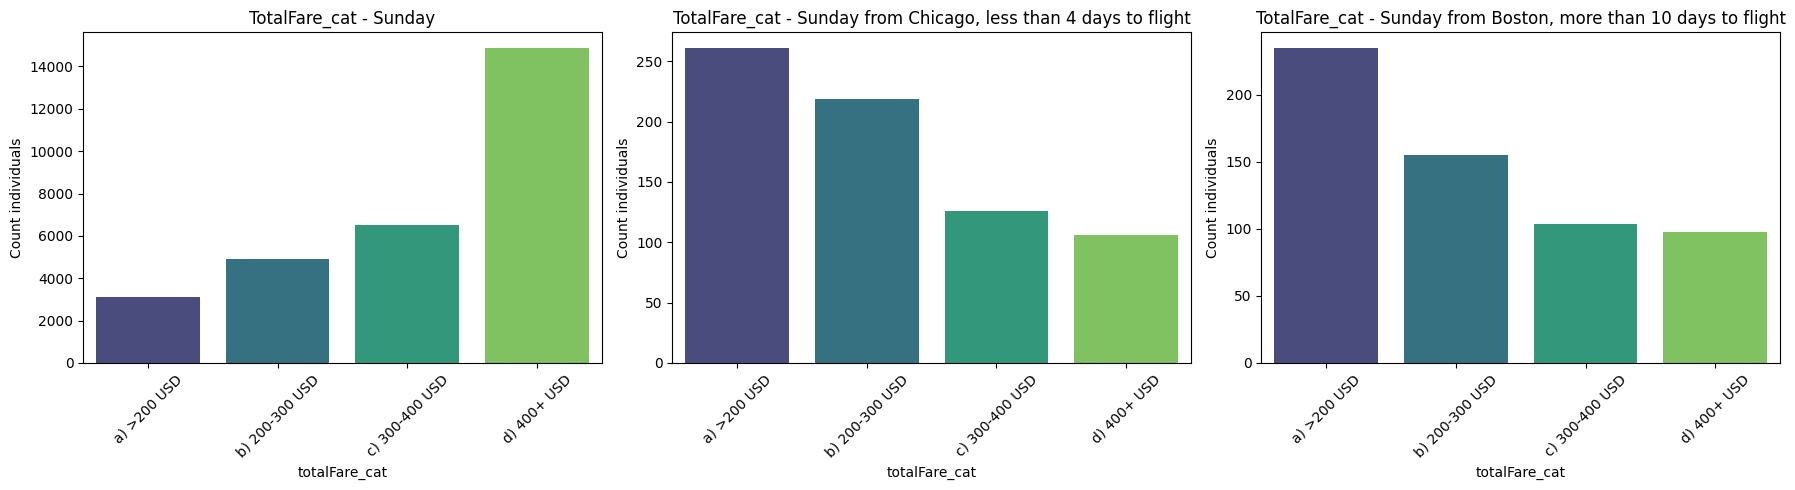

In [49]:
order = sorted(matice['totalFare_cat'].unique())
x1 = matice[(matice['Weekday']=='7 Sun')]
x2 = matice[(matice['Weekday']=='7 Sun') & (matice['startingAirport']=='ORD') & (matice['DaysToFlight_cat']=='a) < 4 Days')]
x3 = matice[(matice['Weekday']=='7 Sun') & (matice['startingAirport']=='BOS') & (matice['DaysToFlight_cat']=='d) 11+ Days')]

fig = plt.figure(figsize=(18,5))
ax1 = fig.add_subplot(1, 3, 1)
#plt.figure(figsize=(10, 6))
sns.countplot(data=x1, x='totalFare_cat', palette='viridis', order= order)
plt.xlabel('totalFare_cat')
plt.ylabel('Count individuals')
plt.title('TotalFare_cat - Sunday')
plt.xticks(rotation=45)
plt.tight_layout()

ax2 = fig.add_subplot(1, 3, 2)
sns.countplot(data=x2, x='totalFare_cat', palette='viridis', order= order)
plt.xlabel('totalFare_cat')
plt.ylabel('Count individuals')
plt.title('TotalFare_cat - Sunday from Chicago, less than 4 days to flight')
plt.xticks(rotation=45)
plt.tight_layout()

ax3 = fig.add_subplot(1, 3, 3)
sns.countplot(data=x3, x='totalFare_cat', palette='viridis', order= order)
plt.xlabel('totalFare_cat')
plt.ylabel('Count individuals')
plt.title('TotalFare_cat - Sunday from Boston, more than 10 days to flight')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

In [10]:
clm = cleverminer(df=matice,target='totalFare_cat',proc='CFMiner',
               quantifiers= {'S_Up':3, 'Base':2000},
               cond ={
                    'attributes':[
                        {'name': 'Weekday', 'type': 'one', 'value': '2 Tue'},
                        {'name': 'dep_time_cat', 'type': 'subset', 'minlen': 1, 'maxlen': 1},
                        {'name': 'seatsRemaining', 'type': 'subset', 'minlen': 1, 'maxlen': 1},
                        {'name': 'DaysToFlight_cat', 'type': 'subset', 'minlen': 1, 'maxlen': 1},
                        {'name': 'startingAirport', 'type': 'subset', 'minlen': 1, 'maxlen': 1},
                        {'name': 'destinationAirport', 'type': 'subset', 'minlen': 1, 'maxlen': 1},
                        {'name': 'tavg_cat', 'type': 'subset', 'minlen': 1, 'maxlen': 1},
                        {'name': 'prcp_cat', 'type': 'subset', 'minlen': 1, 'maxlen': 1},
                        {'name': 'wspd_cat', 'type': 'subset', 'minlen': 1, 'maxlen': 1},
                        {'name': 'elapsedDays', 'type': 'subset', 'minlen': 1, 'maxlen': 1},
                        {'name': 'NumberOfTransfers', 'type': 'subset', 'minlen': 1, 'maxlen': 1},
                        {'name': 'Wait_time_cat', 'type': 'subset', 'minlen': 1, 'maxlen': 1},
                        {'name': 'AirlineNameCount', 'type': 'subset', 'minlen': 1, 'maxlen': 1},
                        {'name': 'AirlineNameSummary', 'type': 'subset', 'minlen': 1, 'maxlen': 1}
                    ], 'minlen':2, 'maxlen':4, 'type':'con'}
               )


clm.print_summary()
clm.print_rulelist()
clm.print_rule(1)

Cleverminer version 1.0.10.
Starting data preparation ...
Automatically reordering numeric categories ...
Encoding columns into bit-form...
Encoding columns into bit-form...done
Data preparation finished.
Will go for  CFMiner
Starting to mine rules.
100%|####################################################|Elapsed Time: 0:00:2929
Done. Total verifications : 27813, rules 5518, times: prep 2.37sec, processing 29.73sec

CleverMiner task processing summary:

Task type : CFMiner
Number of verifications : 27813
Number of rules : 5518
Total time needed : 00h 00m 32s
Time of data preparation : 00h 00m 02s
Time of rule mining : 00h 00m 29s


List of rules:
RULEID BASE  S_UP  S_DOWN Condition
     1  2062     3     0 Weekday(2 Tue) & dep_time_cat(a) Morning) & seatsRemaining(2)
     2  2053     3     0 Weekday(2 Tue) & dep_time_cat(a) Morning) & seatsRemaining(2) & elapsedDays(0)
     3  2127     3     0 Weekday(2 Tue) & dep_time_cat(a) Morning) & tavg_cat(c) 10-20) & AirlineNameCount(2)
     4 


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



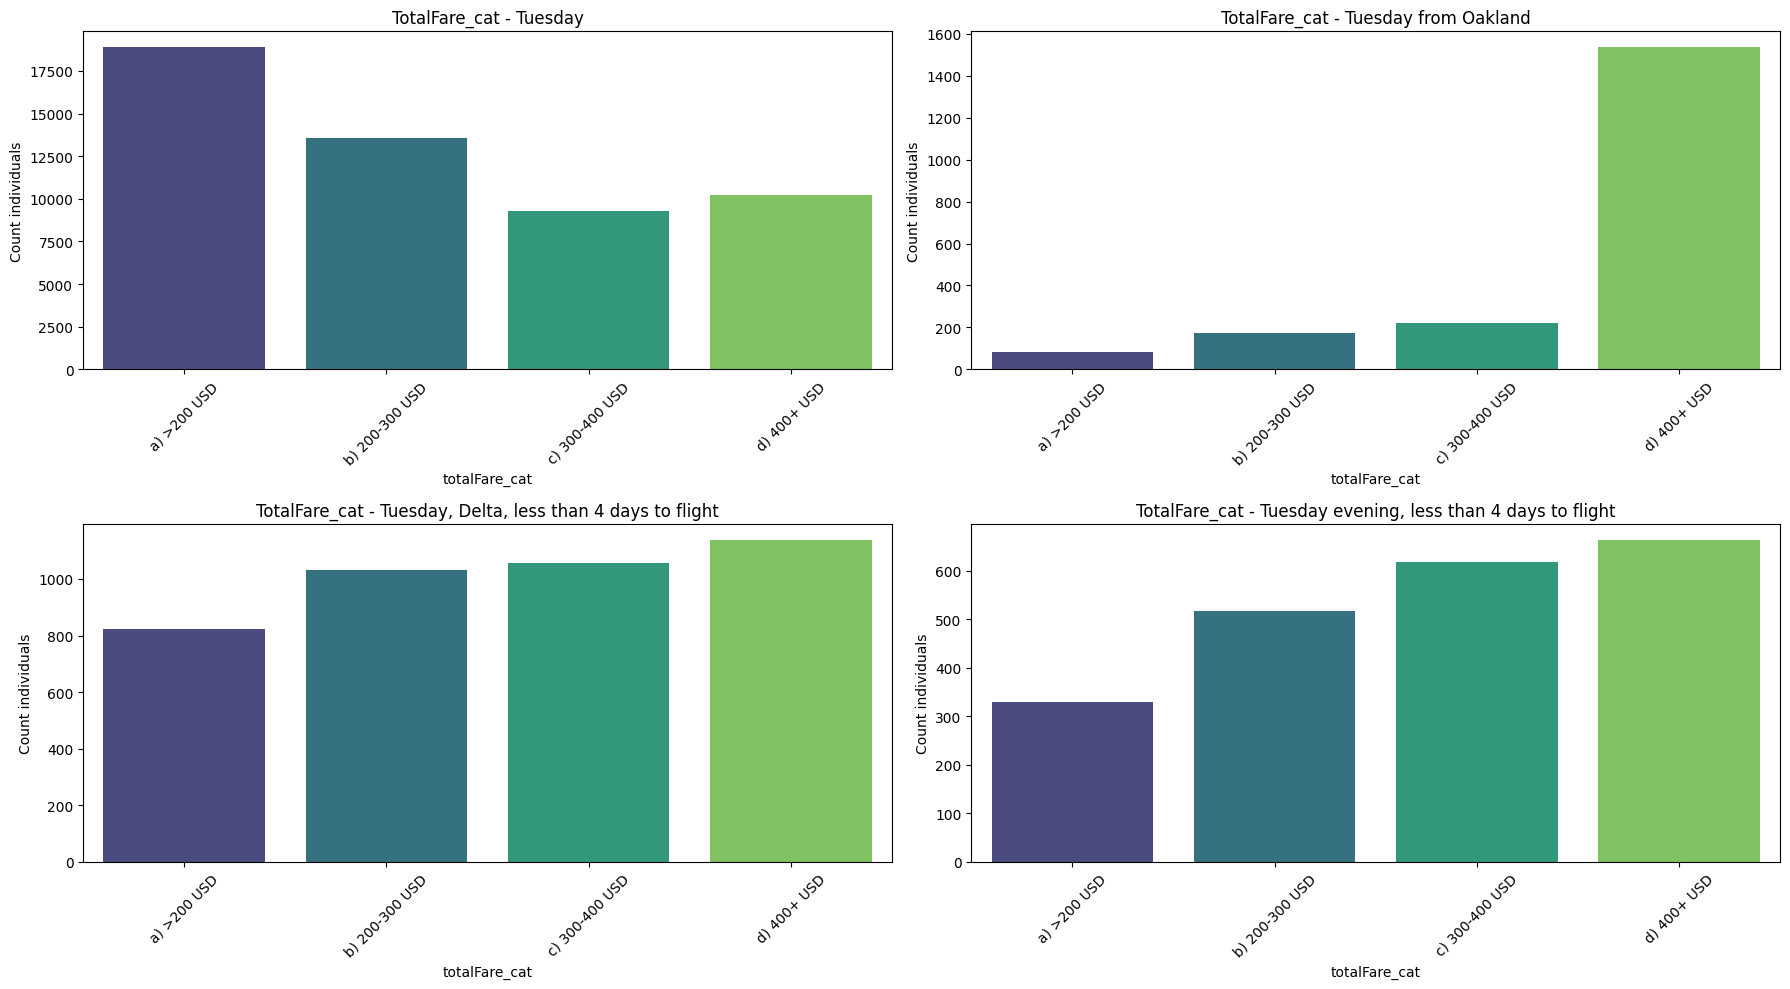

In [72]:
order = sorted(matice['totalFare_cat'].unique())
x1 = matice[(matice['Weekday']=='2 Tue')]
x2 = matice[(matice['Weekday']=='2 Tue') & (matice['destinationAirport']=='OAK')]
x3 = matice[(matice['Weekday']=='2 Tue') & (matice['AirlineNameSummary']=='Delta') & (matice['DaysToFlight_cat']=='a) < 4 Days')]
x4 = matice[(matice['Weekday']=='2 Tue') & (matice['dep_time_cat']=='c) Evening') & (matice['DaysToFlight_cat']=='a) < 4 Days')]

fig = plt.figure(figsize=(18,10))
ax1 = fig.add_subplot(2,2, 1)
sns.countplot(data=x1, x='totalFare_cat', palette='viridis', order= order)
plt.xlabel('totalFare_cat')
plt.ylabel('Count individuals')
plt.title('TotalFare_cat - Tuesday')
plt.xticks(rotation=45)
plt.tight_layout()

ax2 = fig.add_subplot(2, 2, 2)
sns.countplot(data=x2, x='totalFare_cat', palette='viridis', order= order)
plt.xlabel('totalFare_cat')
plt.ylabel('Count individuals')
plt.title('TotalFare_cat - Tuesday from Oakland')
plt.xticks(rotation=45)
plt.tight_layout()

ax3 = fig.add_subplot(2, 2, 3)
sns.countplot(data=x3, x='totalFare_cat', palette='viridis', order= order)
plt.xlabel('totalFare_cat')
plt.ylabel('Count individuals')
plt.title('TotalFare_cat - Tuesday, Delta, less than 4 days to flight')
plt.xticks(rotation=45)
plt.tight_layout()

ax4 = fig.add_subplot(2, 2, 4)
sns.countplot(data=x4, x='totalFare_cat', palette='viridis', order= order)
plt.xlabel('totalFare_cat')
plt.ylabel('Count individuals')
plt.title('TotalFare_cat - Tuesday evening, less than 4 days to flight')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

In [11]:
clm = cleverminer(df=matice,target='totalFare_cat',proc='CFMiner',
               quantifiers= {'S_Up':3, 'Base':2000},
               cond ={
                    'attributes':[
                        {'name': 'Weekday', 'type': 'one', 'value': '3 Wed'},
                        {'name': 'dep_time_cat', 'type': 'subset', 'minlen': 1, 'maxlen': 1},
                        {'name': 'seatsRemaining', 'type': 'subset', 'minlen': 1, 'maxlen': 1},
                        {'name': 'DaysToFlight_cat', 'type': 'subset', 'minlen': 1, 'maxlen': 1},
                        {'name': 'startingAirport', 'type': 'subset', 'minlen': 1, 'maxlen': 1},
                        {'name': 'destinationAirport', 'type': 'subset', 'minlen': 1, 'maxlen': 1},
                        {'name': 'tavg_cat', 'type': 'subset', 'minlen': 1, 'maxlen': 1},
                        {'name': 'prcp_cat', 'type': 'subset', 'minlen': 1, 'maxlen': 1},
                        {'name': 'wspd_cat', 'type': 'subset', 'minlen': 1, 'maxlen': 1},
                        {'name': 'elapsedDays', 'type': 'subset', 'minlen': 1, 'maxlen': 1},
                        {'name': 'NumberOfTransfers', 'type': 'subset', 'minlen': 1, 'maxlen': 1},
                        {'name': 'Wait_time_cat', 'type': 'subset', 'minlen': 1, 'maxlen': 1},
                        {'name': 'AirlineNameCount', 'type': 'subset', 'minlen': 1, 'maxlen': 1},
                        {'name': 'AirlineNameSummary', 'type': 'subset', 'minlen': 1, 'maxlen': 1}
                    ], 'minlen':2, 'maxlen':4, 'type':'con'}
               )


clm.print_summary()
clm.print_rulelist()
clm.print_rule(1)

Cleverminer version 1.0.10.
Starting data preparation ...
Automatically reordering numeric categories ...
Encoding columns into bit-form...
Encoding columns into bit-form...done
Data preparation finished.
Will go for  CFMiner
Starting to mine rules.
100%|####################################################|Elapsed Time: 0:00:2929
Done. Total verifications : 27408, rules 5509, times: prep 2.41sec, processing 29.50sec

CleverMiner task processing summary:

Task type : CFMiner
Number of verifications : 27408
Number of rules : 5509
Total time needed : 00h 00m 31s
Time of data preparation : 00h 00m 02s
Time of rule mining : 00h 00m 29s


List of rules:
RULEID BASE  S_UP  S_DOWN Condition
     1  2344     3     0 Weekday(3 Wed) & dep_time_cat(a) Morning) & DaysToFlight_cat(a) < 4 Days) & tavg_cat(c) 10-20)
     2  2366     3     0 Weekday(3 Wed) & dep_time_cat(a) Morning) & DaysToFlight_cat(b) 4 - 7 Days) & tavg_cat(c) 10-20)
     3  2430     3     0 Weekday(3 Wed) & dep_time_cat(a) Morning)


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

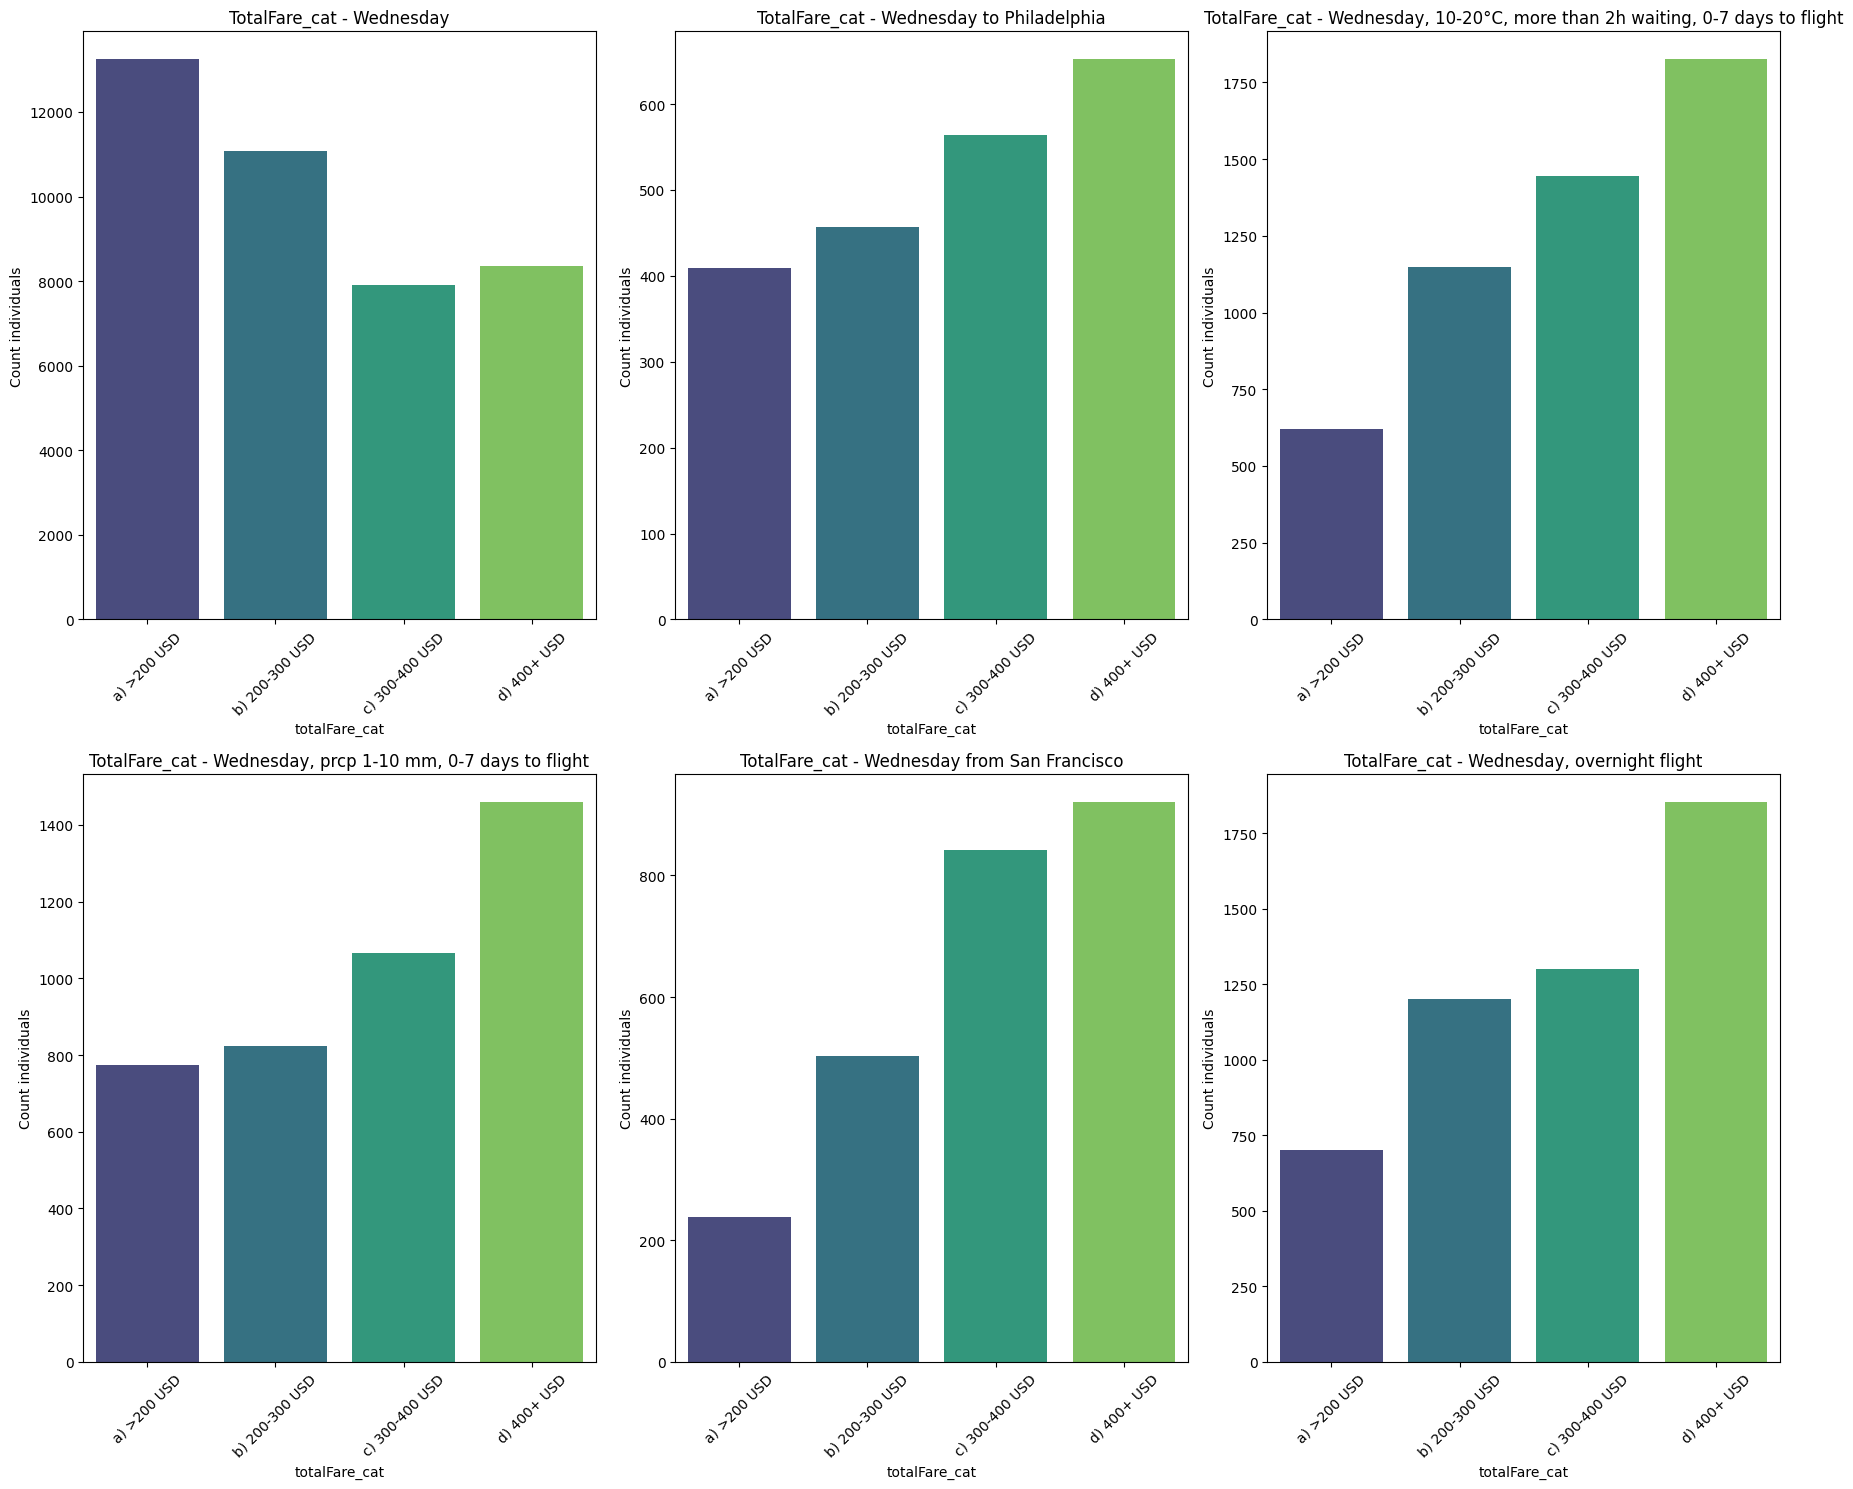

In [60]:
order = sorted(matice['totalFare_cat'].unique())
x1 = matice[(matice['Weekday']=='3 Wed')]
x2 = matice[(matice['Weekday']=='3 Wed') & (matice['destinationAirport']=='PHL')]
x3 = matice[(matice['Weekday']=='3 Wed') & (matice['tavg_cat']=='c) 10-20') & (matice['Wait_time_cat']=='c) 2+ h') & ((matice['DaysToFlight_cat']=='a) < 4 Days') | (matice['DaysToFlight_cat']=='b) 4 - 7 Days'))]
x4 = matice[(matice['Weekday']=='3 Wed') & (matice['prcp_cat']=='b) 1-10') & ((matice['DaysToFlight_cat']=='a) < 4 Days') | (matice['DaysToFlight_cat']=='b) 4 - 7 Days'))]
x5 = matice[(matice['Weekday']=='3 Wed') & (matice['startingAirport']=='SFO')]
x6 = matice[(matice['Weekday']=='3 Wed') & (matice['elapsedDays'] == 1)]

fig = plt.figure(figsize=(18,15))
ax1 = fig.add_subplot(2, 3, 1)
sns.countplot(data=x1, x='totalFare_cat', palette='viridis', order= order)
plt.xlabel('totalFare_cat')
plt.ylabel('Count individuals')
plt.title('TotalFare_cat - Wednesday')
plt.xticks(rotation=45)
plt.tight_layout()

ax2 = fig.add_subplot(2, 3, 2)
sns.countplot(data=x2, x='totalFare_cat', palette='viridis', order= order)
plt.xlabel('totalFare_cat')
plt.ylabel('Count individuals')
plt.title('TotalFare_cat - Wednesday to Philadelphia')
plt.xticks(rotation=45)
plt.tight_layout()

ax3 = fig.add_subplot(2, 3, 3)
sns.countplot(data=x3, x='totalFare_cat', palette='viridis', order= order)
plt.xlabel('totalFare_cat')
plt.ylabel('Count individuals')
plt.title('TotalFare_cat - Wednesday, 10-20°C, more than 2h waiting, 0-7 days to flight')
plt.xticks(rotation=45)
plt.tight_layout()

ax4 = fig.add_subplot(2, 3, 4)
sns.countplot(data=x4, x='totalFare_cat', palette='viridis', order= order)
plt.xlabel('totalFare_cat')
plt.ylabel('Count individuals')
plt.title('TotalFare_cat - Wednesday, prcp 1-10 mm, 0-7 days to flight')
plt.xticks(rotation=45)
plt.tight_layout()

ax5 = fig.add_subplot(2, 3, 5)
sns.countplot(data=x5, x='totalFare_cat', palette='viridis', order= order)
plt.xlabel('totalFare_cat')
plt.ylabel('Count individuals')
plt.title('TotalFare_cat - Wednesday from San Francisco')
plt.xticks(rotation=45)
plt.tight_layout()

ax6 = fig.add_subplot(2, 3, 6)
sns.countplot(data=x6, x='totalFare_cat', palette='viridis', order= order)
plt.xlabel('totalFare_cat')
plt.ylabel('Count individuals')
plt.title('TotalFare_cat - Wednesday, overnight flight')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

In [63]:
clm = cleverminer(df=matice,target='totalFare_cat',proc='CFMiner',
               quantifiers= {'S_Down':3, 'Base':2000},
               cond ={
                    'attributes':[
                        {'name': 'Weekday', 'type': 'one', 'value': '1 Mon'},
                        {'name': 'dep_time_cat', 'type': 'subset', 'minlen': 1, 'maxlen': 1},
                        {'name': 'seatsRemaining', 'type': 'subset', 'minlen': 1, 'maxlen': 1},
                        {'name': 'DaysToFlight_cat', 'type': 'subset', 'minlen': 1, 'maxlen': 1},
                        {'name': 'startingAirport', 'type': 'subset', 'minlen': 1, 'maxlen': 1},
                        {'name': 'destinationAirport', 'type': 'subset', 'minlen': 1, 'maxlen': 1},
                        {'name': 'tavg_cat', 'type': 'subset', 'minlen': 1, 'maxlen': 1},
                        {'name': 'prcp_cat', 'type': 'subset', 'minlen': 1, 'maxlen': 1},
                        {'name': 'wspd_cat', 'type': 'subset', 'minlen': 1, 'maxlen': 1},
                        {'name': 'elapsedDays', 'type': 'subset', 'minlen': 1, 'maxlen': 1},
                        {'name': 'NumberOfTransfers', 'type': 'subset', 'minlen': 1, 'maxlen': 1},
                        {'name': 'Wait_time_cat', 'type': 'subset', 'minlen': 1, 'maxlen': 1},
                        {'name': 'AirlineNameCount', 'type': 'subset', 'minlen': 1, 'maxlen': 1},
                        {'name': 'AirlineNameSummary', 'type': 'subset', 'minlen': 1, 'maxlen': 1}
                    ], 'minlen':2, 'maxlen':3, 'type':'con'}
               )


clm.print_summary()
clm.print_rulelist()
clm.print_rule(1)




Cleverminer version 1.0.10.
Starting data preparation ...
Automatically reordering numeric categories ...
Encoding columns into bit-form...
Encoding columns into bit-form...done
Data preparation finished.
Will go for  CFMiner
Starting to mine rules.
100%|####################################################|Elapsed Time: 0:00:0707
Done. Total verifications : 9795, rules 1415, times: prep 2.25sec, processing 7.70sec

CleverMiner task processing summary:

Task type : CFMiner
Number of verifications : 9795
Number of rules : 1415
Total time needed : 00h 00m 09s
Time of data preparation : 00h 00m 02s
Time of rule mining : 00h 00m 07s


List of rules:
RULEID BASE  S_UP  S_DOWN Condition
     1  3189     0     3 Weekday(1 Mon) & dep_time_cat(b) Afternoon) & seatsRemaining(7)
     2  2745     0     3 Weekday(1 Mon) & dep_time_cat(b) Afternoon) & DaysToFlight_cat(d) 11+ Days)
     3  2712     0     3 Weekday(1 Mon) & dep_time_cat(b) Afternoon) & tavg_cat(d) 20-30)
     4  4417     0     3 Weekda

List of rules:

RULEID BASE  S_UP  S_DOWN Condition

     1  3189     0     3 Weekday(1 Mon) & dep_time_cat(b) Afternoon) & seatsRemaining(7)
     2  2745     0     3 Weekday(1 Mon) & dep_time_cat(b) Afternoon) & DaysToFlight_cat(d) 11+ Days)
     4  4417     0     3 Weekday(1 Mon) & dep_time_cat(b) Afternoon) & NumberOfTransfers(0)
     6  2066     0     3 Weekday(1 Mon) & dep_time_cat(c) Evening) & NumberOfTransfers(0)
     8  4432     0     3 Weekday(1 Mon) & seatsRemaining(7) & NumberOfTransfers(0)
    10  2474     0     3 Weekday(1 Mon) & seatsRemaining(9) & NumberOfTransfers(0)
    12  2231     0     3 Weekday(1 Mon) & seatsRemaining(9) & AirlineNameSummary(United)
    14  2580     0     3 Weekday(1 Mon) & DaysToFlight_cat(d) 11+ Days) & NumberOfTransfers(0)
    17  2472     0     3 Weekday(1 Mon) & DaysToFlight_cat(d) 11+ Days) & AirlineNameSummary(American Airlines)
    18  2000     0     3 Weekday(1 Mon) & DaysToFlight_cat(d) 11+ Days) & AirlineNameSummary(United)
    20  2991     0     3 Weekday(1 Mon) & startingAirport(BOS) & AirlineNameCount(1)
    22  3135     0     3 Weekday(1 Mon) & startingAirport(LGA) & AirlineNameCount(1)
    23  2776     0     3 Weekday(1 Mon) & startingAirport(ORD)

Zřejmě lichý počet zbývajících míst snižuje cenu za jistých okolností???

Samozřejmě přímé lety levnější, stejně tak ty dlouho dopředu koupené.


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

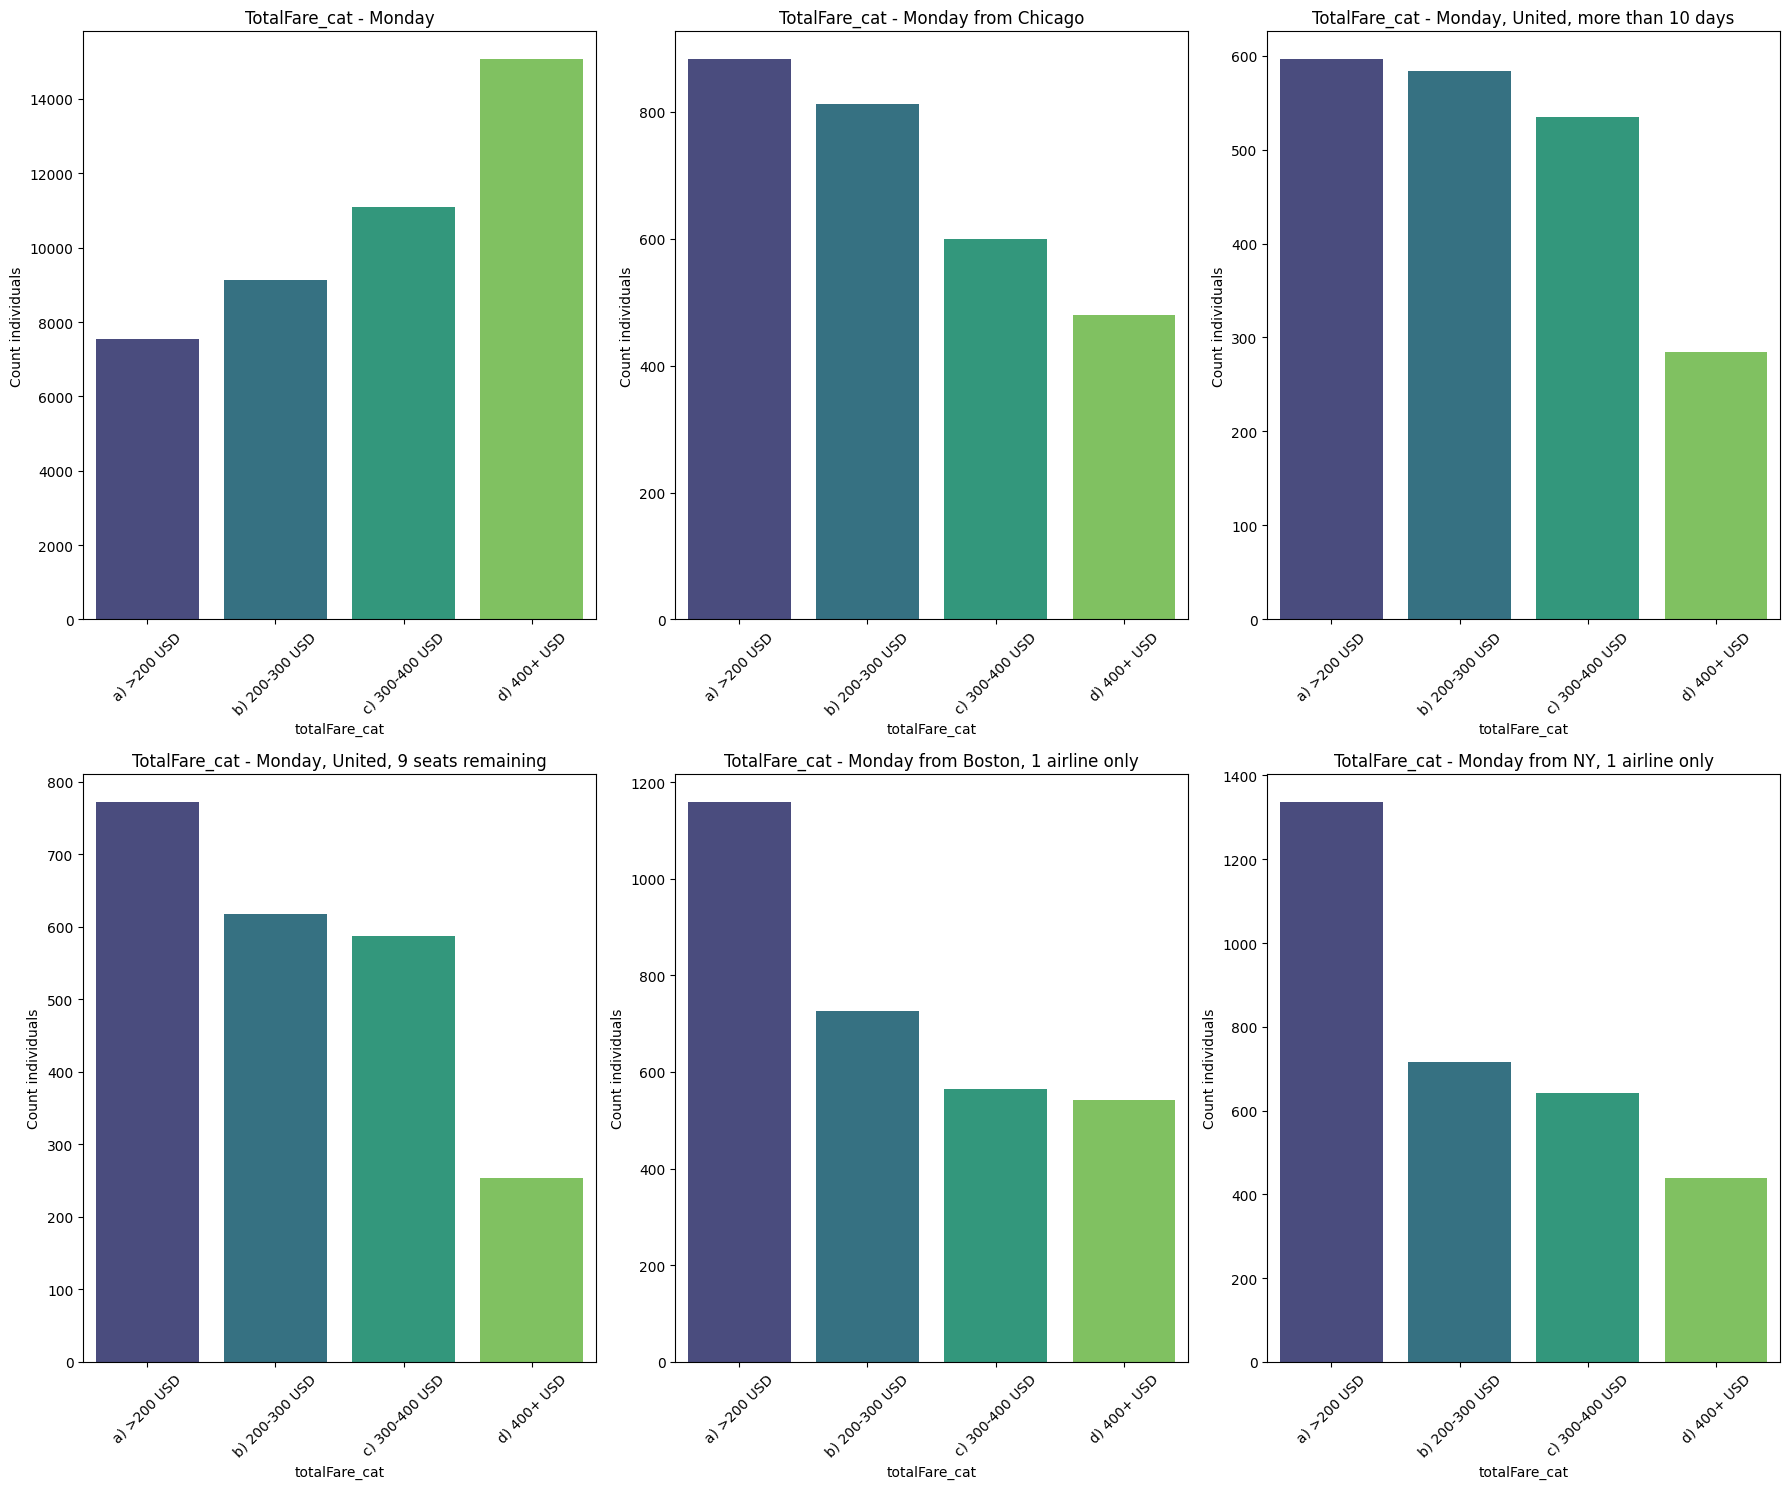

In [73]:
order = sorted(matice['totalFare_cat'].unique())
x1 = matice[(matice['Weekday']=='1 Mon')]
x2 = matice[(matice['Weekday']=='1 Mon') & (matice['startingAirport']=='ORD')]
#x3 = matice[(matice['Weekday']=='1 Mon') & (matice['dep_time_cat']=='b) Afternoon') & (matice['NumberOfTransfers'] == 0)]
x5 = matice[(matice['Weekday']=='1 Mon') & (matice['AirlineNameSummary']=='United') & (matice['DaysToFlight_cat']=='d) 11+ Days')]
x6 = matice[(matice['Weekday']=='1 Mon') & (matice['AirlineNameSummary']=='United') & (matice['seatsRemaining'] == 9)]
x7 = matice[(matice['Weekday']=='1 Mon') & (matice['startingAirport']=='BOS') & (matice['AirlineNameCount']==1)]
x8 = matice[(matice['Weekday']=='1 Mon') & (matice['startingAirport']=='LGA') & (matice['AirlineNameCount']==1)]
#x4 = matice[(matice['Weekday']=='1 Mon') & (matice['NumberOfTransfers'] == 0) & (matice['seatsRemaining'] == 7)]

fig = plt.figure(figsize=(18,15))
ax1 = fig.add_subplot(2, 3, 1)
sns.countplot(data=x1, x='totalFare_cat', palette='viridis', order= order)
plt.xlabel('totalFare_cat')
plt.ylabel('Count individuals')
plt.title('TotalFare_cat - Monday')
plt.xticks(rotation=45)
plt.tight_layout()

ax2 = fig.add_subplot(2, 3, 2)
sns.countplot(data=x2, x='totalFare_cat', palette='viridis', order= order)
plt.xlabel('totalFare_cat')
plt.ylabel('Count individuals')
plt.title('TotalFare_cat - Monday from Chicago')
plt.xticks(rotation=45)
plt.tight_layout()

ax5 = fig.add_subplot(2, 3, 3)
sns.countplot(data=x5, x='totalFare_cat', palette='viridis', order= order)
plt.xlabel('totalFare_cat')
plt.ylabel('Count individuals')
plt.title('TotalFare_cat - Monday, United, more than 10 days')
plt.xticks(rotation=45)
plt.tight_layout()

ax6 = fig.add_subplot(2, 3, 4)
sns.countplot(data=x6, x='totalFare_cat', palette='viridis', order= order)
plt.xlabel('totalFare_cat')
plt.ylabel('Count individuals')
plt.title('TotalFare_cat - Monday, United, 9 seats remaining')
plt.xticks(rotation=45)
plt.tight_layout()

ax7 = fig.add_subplot(2, 3, 5)
sns.countplot(data=x7, x='totalFare_cat', palette='viridis', order= order)
plt.xlabel('totalFare_cat')
plt.ylabel('Count individuals')
plt.title('TotalFare_cat - Monday from Boston, 1 airline only')
plt.xticks(rotation=45)
plt.tight_layout()

ax8 = fig.add_subplot(2, 3, 6)
sns.countplot(data=x8, x='totalFare_cat', palette='viridis', order= order)
plt.xlabel('totalFare_cat')
plt.ylabel('Count individuals')
plt.title('TotalFare_cat - Monday from NY, 1 airline only')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()